In [50]:
import os

PATH = "/cmlscratch/ani01/.cache/huggingface"
os.environ['HF_HOME'] = PATH
os.environ['TRANSFORMERS_CACHE'] = PATH + "/" + "models"
os.environ['HF_DATASETS_CACHE'] = PATH + "/" + "datasets"
os.environ['TORCH_HOME'] = "/cmlscratch/ani01/.cache/torch"

In [114]:
# Add project root to sys.path
import sys, os

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

import utils 

import importlib
importlib.reload(utils.vlm_inference_helper)
importlib.reload(utils.prompt_templates)
importlib.reload(utils.process_vlm_io)
importlib.reload(utils.evaluation_metrics)
importlib.reload(utils.show_results)

from utils.vlm_inference_helper import Phi35, LlaVa16, InternVL25
from utils.prompt_templates import PROMPT_TEMPLATES
from utils.process_vlm_io import process_pred_csv, get_chart_pair_images, data_alignment_str_to_json
from utils.evaluation_metrics import get_data_grounding_score, compute_alignment_score
from utils.show_results import show_chart_grounding, show_chart_alignment

In [30]:
from datasets import load_dataset
import json
from PIL import Image

from IPython.display import display

In [31]:
dataset = load_dataset("aniruddhbansal2000/sample_dataset", "data_grounding_and_alignment")["test"]

Using the latest cached version of the dataset since aniruddhbansal2000/sample_dataset couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'data_grounding_and_alignment' at /cmlscratch/ani01/.cache/huggingface/datasets/aniruddhbansal2000___sample_dataset/data_grounding_and_alignment/0.0.0/3f4a6da2df1f081ee19b770d07e72c414623a99b (last modified on Tue Oct 21 18:21:52 2025).


In [158]:
sample = dataset[96]
sample

{'idx': 96,
 'imgname': 'bar_num_136',
 'chart_type': 'bar_chart_num',
 'num_cell_difference': 2,
 'chart_1_grounding': 'Country \t Crops(tons) \t Fruits(tons) \t Vegetables(tons) \n USA \t 20000 \t 50000 \t 100000 \n Canada \t 15000 \t 45000 \t 80000 \n Mexico \t 18000 \t 48000 \t 95000 \n Brazil \t 30000 \t 60000 \t 110000 \n ',
 'chart_2_grounding': 'Country \t Crops(tons) \t Fruits(tons) \t Vegetables(tons) \n USA \t 20000 \t 50000 \t 100000 \n Canada \t 15000 \t 45000 \t 48125 \n Mexico \t 18000 \t 48000 \t 95000 \n Brazil \t 30000 \t 60000 \t 144375 \n ',
 'alignment_json': '{"0": {"row name": "Canada", "column name": "Vegetables(tons)", "value in chart 1": 80000, "value in chart 2": 48125}, "1": {"row name": "Brazil", "column name": "Vegetables(tons)", "value in chart 1": 110000, "value in chart 2": 144375}}',
 'image_pair': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=2000x600>}

In [159]:
img = sample["image_pair"]
img
chart_1_img, chart_2_img = get_chart_pair_images(img)

In [154]:
VLM_obj = Phi35()

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3.5-vision-instruct:
- configuration_phi3_v.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3.5-vision-instruct:
- modeling_phi3_v.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3.5-vision-instruct:
- processing_phi3_v.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
/cmlscratch/ani01/.conda/miniconda/envs/phi_3/lib/python3.10/site-packages/transformers/models/auto/image_processing_auto.py:510: FutureWarning: The image_processor_class argument is deprecated and will be removed in v4.42. Please use `slow_image_processor_class`, or `fast_image_processor_class` instead
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [160]:
data_grounding_prompt = PROMPT_TEMPLATES["data"]["grounding"]

chart_1_pred_grounding = process_pred_csv(VLM_obj.infer(prompt_text_template = data_grounding_prompt, images_list = [chart_1_img]))
chart_2_pred_grounding = process_pred_csv(VLM_obj.infer(prompt_text_template = data_grounding_prompt, images_list = [chart_2_img]))

chart_1_gt_grounding = sample['chart_1_grounding']
chart_2_gt_grounding = sample['chart_2_grounding']

chart_1_grounding_score = get_data_grounding_score(chart_1_gt_grounding, chart_1_pred_grounding)
chart_2_grounding_score = get_data_grounding_score(chart_2_gt_grounding, chart_2_pred_grounding)

In [161]:
# print(f"chart 1 predicted grounding: {chart_1_pred_grounding}")
# print(f"chart 1 ground-truth grounding: {chart_1_gt_grounding}")

# print(f"chart 2 predicted grounding: {chart_2_pred_grounding}")
# print(f"chart 2 ground-truth grounding: {chart_2_gt_grounding}")

chart 1 predicted grounding: Country	Crops	Fruits	Vegetables
USA	25000	50000	100000
Canada	20000	45000	80000
Mexico	30000	40000	90000
Brazil	35000	55000	120000

chart 1 ground-truth grounding: Country 	 Crops(tons) 	 Fruits(tons) 	 Vegetables(tons) 
 USA 	 20000 	 50000 	 100000 
 Canada 	 15000 	 45000 	 80000 
 Mexico 	 18000 	 48000 	 95000 
 Brazil 	 30000 	 60000 	 110000 
 
chart 2 predicted grounding: Country	Crops	Fruits	Vegetables
USA	20000	50000	100000
Canada	15000	45000	50000
Mexico	25000	30000	75000
Brazil	30000	60000	150000

chart 2 ground-truth grounding: Country 	 Crops(tons) 	 Fruits(tons) 	 Vegetables(tons) 
 USA 	 20000 	 50000 	 100000 
 Canada 	 15000 	 45000 	 48125 
 Mexico 	 18000 	 48000 	 95000 
 Brazil 	 30000 	 60000 	 144375 
 


Country,Crops,Fruits,Vegetables
USA,20000,50000,100000
Canada,15000,45000,80000
Mexico,18000,48000,95000
Brazil,30000,60000,110000
Country,Crops,Fruits,Vegetables
USA,25000,50000,100000
Canada,20000,45000,80000
Mexico,30000,40000,90000
Brazil,35000,55000,120000
Country,Crops,Fruits,Vegetables

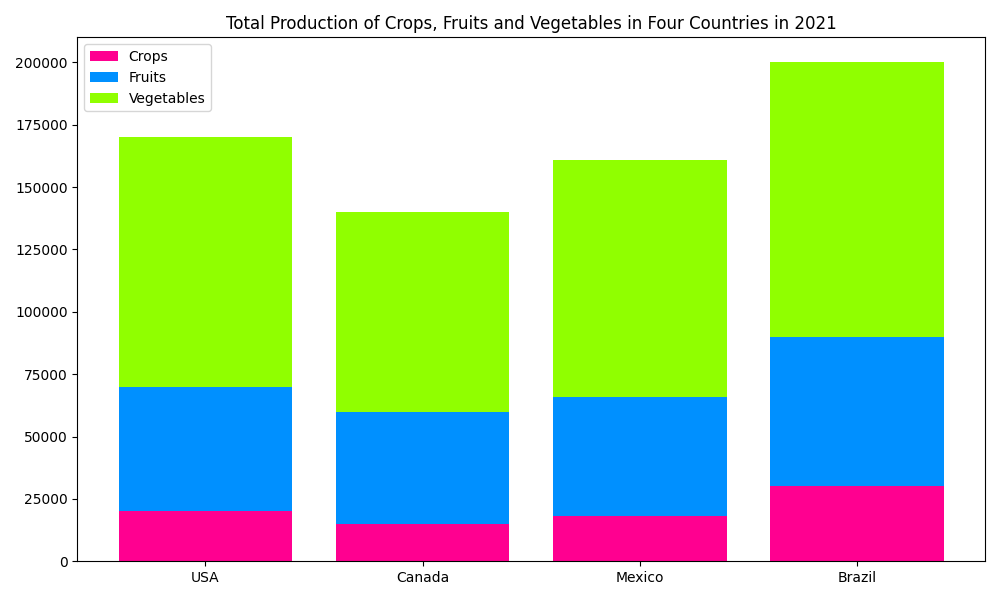
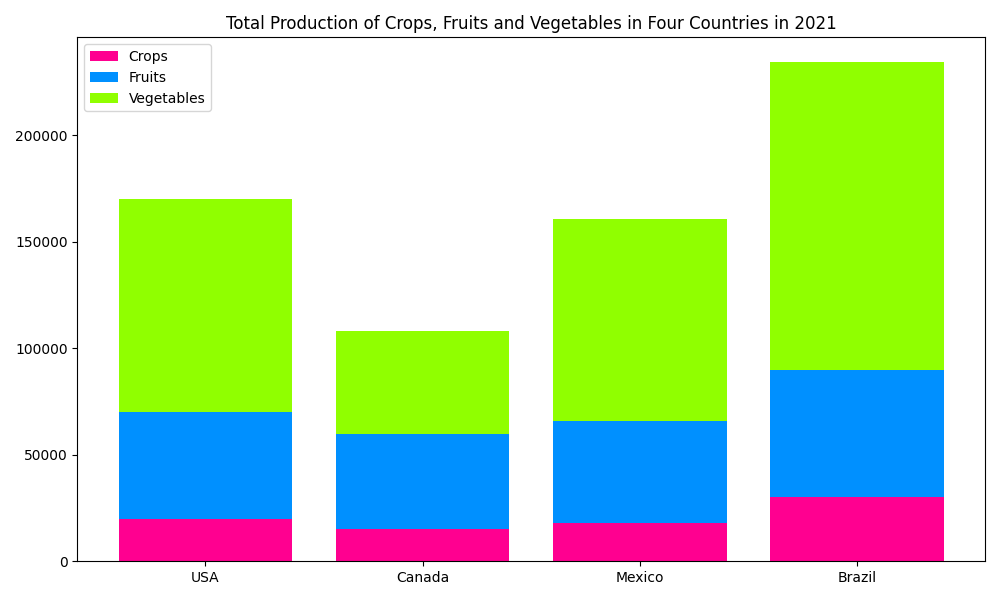

In [162]:

show_chart_grounding(chart_1_img, chart_2_img, chart_1_gt_grounding, chart_1_pred_grounding, chart_2_pred_grounding, chart_2_pred_grounding, chart_1_grounding_score, chart_2_grounding_score, show_as_table = True)


In [165]:
num_cell_difference = sample["num_cell_difference"]

data_alignment_prompt = PROMPT_TEMPLATES["data"]["alignment"]
data_alignment_prompt = data_alignment_prompt.replace("image_1_predicted_grounding_tag", chart_1_pred_grounding)
data_alignment_prompt = data_alignment_prompt.replace("image_2_predicted_grounding_tag", chart_2_pred_grounding)
data_alignment_prompt = data_alignment_prompt.replace("cells_change_cnt_tag", f"{num_cell_difference}")
if num_cell_difference == 1: # singular
    data_alignment_prompt = data_alignment_prompt.replace("cell(s)", "cell")
else:                     # plural
    data_alignment_prompt = data_alignment_prompt.replace("cell(s)", "cells")

pred_alignment_json = data_alignment_str_to_json(VLM_obj.infer(prompt_text_template = data_alignment_prompt), num_cell_difference)
gt_alignment_json = json.loads(sample['alignment_json'])

print(f"predicted alignment is: {pred_alignment_json}")
print(f"ground-truth alignment is: {gt_alignment_json}")

[{"row name": "USA", "column name": "Crops", "value in chart 1": 25000, "value in chart 2": 20000}, {"row name": "Canada", "column name": "Vegetables", "value in chart 1": 100000, "value in chart 2": 50000}]
predicted alignment is: {0: {'row name': 'USA', 'column name': 'Crops', 'value in chart 1': 25000, 'value in chart 2': 20000}, 1: {'row name': 'Canada', 'column name': 'Vegetables', 'value in chart 1': 100000, 'value in chart 2': 50000}}
ground-truth alignment is: {'0': {'row name': 'Canada', 'column name': 'Vegetables(tons)', 'value in chart 1': 80000, 'value in chart 2': 48125}, '1': {'row name': 'Brazil', 'column name': 'Vegetables(tons)', 'value in chart 1': 110000, 'value in chart 2': 144375}}


{0: {'row name': 'USA', 'column name': 'Crops', 'value in chart 1': 25000, 'value in chart 2': 20000}, 1: {'row name': 'Canada', 'column name': 'Vegetables', 'value in chart 1': 100000, 'value in chart 2': 50000}}
{'0': {'row name': 'Canada', 'column name': 'Vegetables(tons)', 'value in chart 1': 80000, 'value in chart 2': 48125}, '1': {'row name': 'Brazil', 'column name': 'Vegetables(tons)', 'value in chart 1': 110000, 'value in chart 2': 144375}}



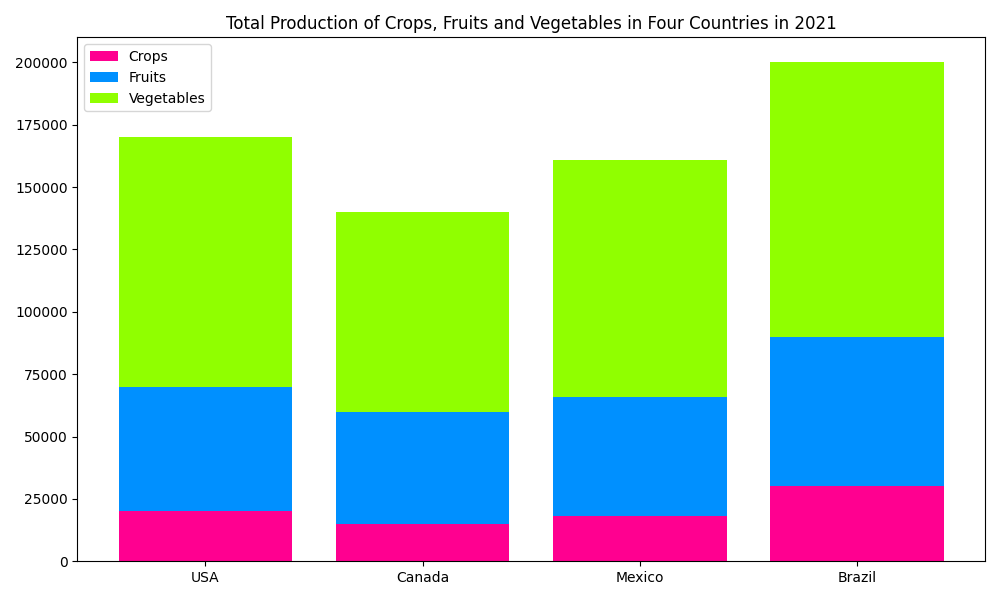
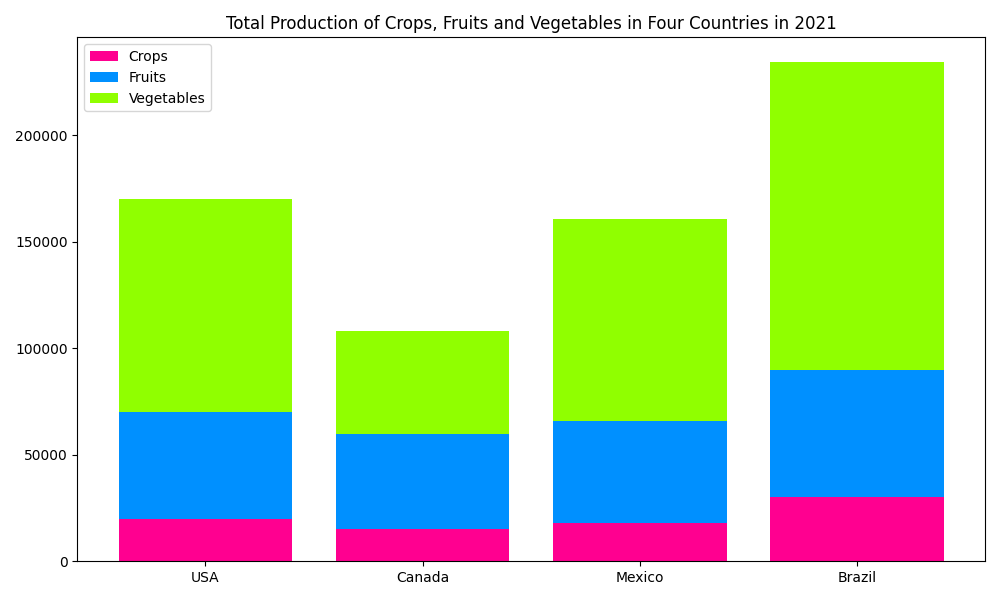

In [166]:
alignment_score = compute_alignment_score(pred_alignment_json, gt_alignment_json, "data")

show_chart_alignment(
    chart_1_img, chart_2_img, gt_alignment_json, pred_alignment_json, alignment_score
)


In [ ]:
# import pandas as pd
# from IPython.display import display, HTML
# import io

# display(chart_1_img)

# def clean_csv_string(csv_str):
#     # Remove units and excess whitespace
#     csv_str = csv_str.replace("(million)", "")
#     csv_str = csv_str.replace("\t", ",")
#     # Remove double spaces and trim
#     csv_str = "\n".join([",".join(col.strip() for col in line.split(",")) 
#                          for line in csv_str.strip().splitlines() if line.strip()])
#     return csv_str


# def df_to_triplets(df):
#     return set((r, c, str(df.at[r, c])) for r in df.index for c in df.columns)

# def show_grounding_comparison(gt_grounding, pred_grounding):
#     import pandas as pd, io
#     gt_csv = clean_csv_string(gt_grounding)
#     pred_csv = clean_csv_string(pred_grounding)

#     gt_df = pd.read_csv(io.StringIO(gt_csv), dtype=str)
#     pred_df = pd.read_csv(io.StringIO(pred_csv), dtype=str)

#     print("Chart 1: GT Grounding")
#     display(gt_df)
#     display(pred_df)

#     gt_triples = df_to_triplets(gt_df)
#     pred_triples = df_to_triplets(pred_df)
    
#     added = pred_triples - gt_triples
#     missing = gt_triples - pred_triples

#     print(added)
#     print(missing)

#     # differences = gt_df.compare(pred_df, keep_equal=False, result_names=('GT', 'Pred'))
#     # display(differences)



# # def show_grounding_comparison(gt_grounding, pred_grounding):
    
# #     gt_grounding = gt_grounding.replace("\t", ",").replace("(million)", "")
# #     pred_grounding = pred_grounding[1:]

# #     gt_df = pd.read_csv(io.StringIO(gt_grounding), dtype=str)
# #     predicted_df = pd.read_csv(io.StringIO(pred_grounding), dtype=str)

# #     print(gt_df)
# #     print(predicted_df)

# #     differences = gt_df.compare(predicted_df, keep_equal=False, result_names=('file1', 'file2'))
# #     print(differences)
    
# #     # df = pd.DataFrame({
# #     #     "Ground Truth Grounding": gt_grounding.split("\n"),
# #     #     "Predicted Grounding": pred_grounding.split("\n")
# #     # })
# #     # display(HTML(df.to_html(index=False)))

# show_grounding_comparison(sample['chart_2_grounding'], chart_2_predicted_grounding)